In [21]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))

from sgpi import model

import sqlalchemy as sa
from sqlalchemy import orm, func, or_

from sgpi.plot import *

import pandas as pd
import pysgpp as sg

In [22]:
# First get the estimators with the best CV-MSE from the database
ses = model.make_session()
best_results = ses.query(model.Result, func.min(model.Result.validation_mse)).\
    filter(model.Result.experiment_id.between(51,100)).\
    join(model.RegularizationConfig).\
    join(model.GridConfig).\
    filter(model.GridConfig.level == 5).\
    filter(or_(model.RegularizationConfig.exponent_base == 1.0, model.RegularizationConfig.type == sg.RegularizationType_Identity)).\
    filter(model.RegularizationConfig.exponent_base == 1.0).\
    group_by(model.GridConfig.T)


In [48]:
rmses = []
mses = []
Ts = []
lambdas = []
num_points = []
for res, mse in best_results:
    mses.append(mse)
    rmses.append(np.sqrt(mse))
    Ts.append(res.grid_config.T)
    lambdas.append(res.regularization_config.lambda_reg)
    num_points.append(res.train_grid_points)
    # Generate code for latex-table
    print "{} & {} & {:2.2f} & {:1.5f} & {:2.3f} & {} & {:2.3f} & {:2.3f}\\\\".\
        format(res.grid_config.T, 
               res.validation_grid_points_mean,res.validation_grid_points_stdev,
               res.regularization_config.lambda_reg, res.validation_mse, res.train_grid_points, res.train_mse, res.test_mse)

-0.4 & 8468.7 & 20.60 & 0.01928 & 22.116 & 8470.0 & 5.174 & 17.763\\
0 & 6678.3 & 27.08 & 0.01962 & 22.175 & 6650.0 & 5.227 & 17.508\\
0.5 & 1140.4 & 23.88 & 0.00629 & 22.761 & 1180.0 & 7.099 & 14.414\\
0.6 & 712.7 & 24.21 & 0.01270 & 22.855 & 685.0 & 11.545 & 18.556\\
1 & 517.9 & 23.32 & 0.01015 & 24.300 & 516.0 & 13.162 & 20.318\\


(-0.20000000000000001, 1.0)

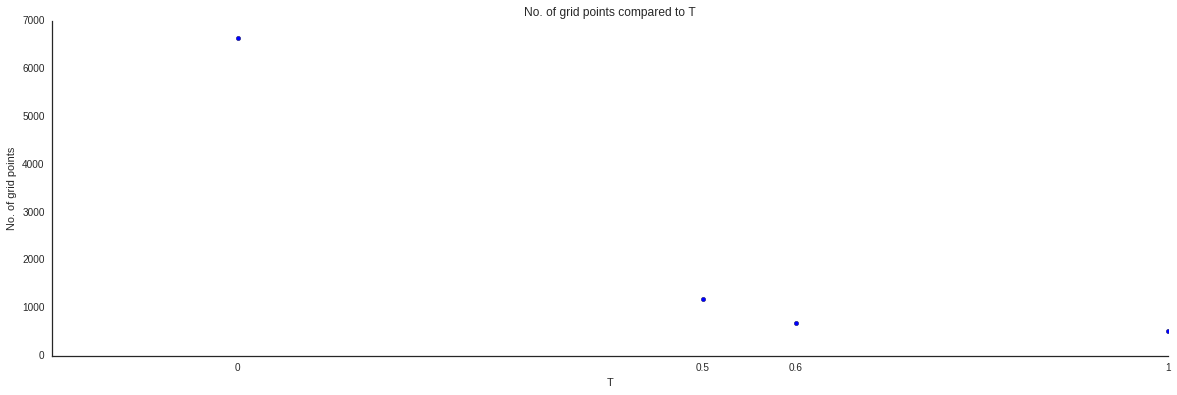

In [60]:
fig, ax = plt.subplots()
sns.despine(fig, ax)
ax.scatter(Ts, num_points)
ax.set_title("No. of grid points compared to T")
ax.set_xlabel("T")
ax.set_ylabel("No. of grid points")
ax.set_xticks(Ts)
ax.set_xticklabels(Ts)

ax.set_xlim(None, 1.0)

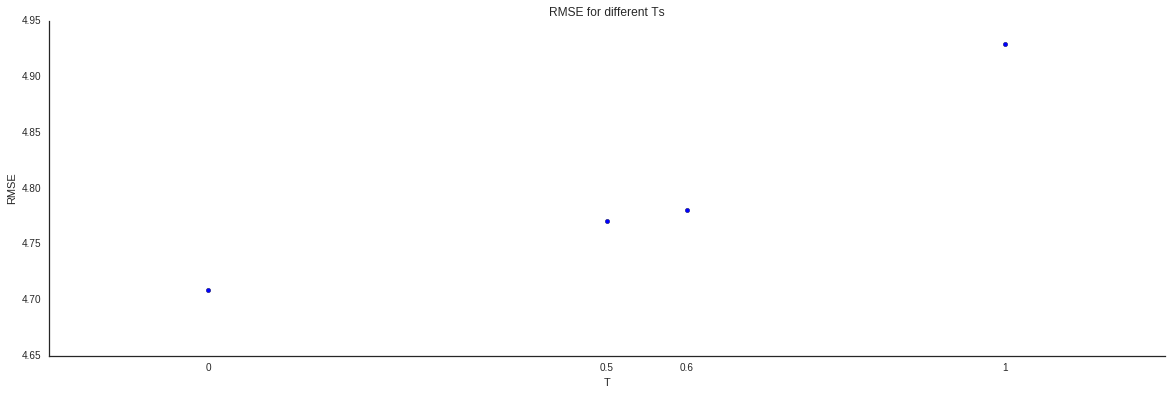

In [61]:
fig, ax = plt.subplots()
sns.despine(fig, ax)
ax.scatter(Ts, rmses)
ax.set_title("RMSE for different Ts")
ax.set_xlabel("T")
ax.set_ylabel("RMSE")
ax.set_xticks(Ts)
ax.set_xticklabels(Ts)


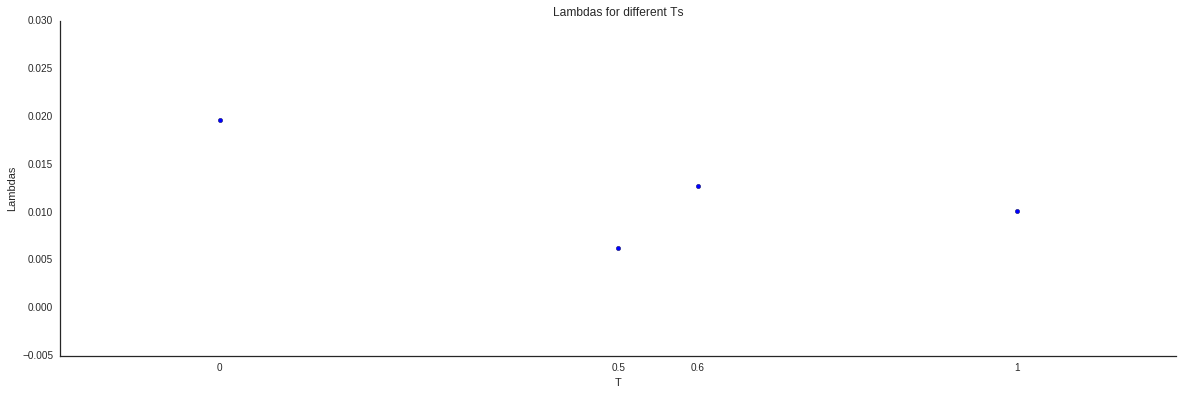

In [62]:
fig, ax = plt.subplots()
sns.despine(fig, ax)
ax.scatter(Ts, lambdas)
ax.set_title("Lambdas for different Ts")
ax.set_xlabel("T")
ax.set_ylabel("Lambdas")
ax.set_xticks(Ts)
ax.set_xticklabels(Ts)

In [36]:
Ts, lambdas, mses

([0, 0, 0.5, 0.5, 0.6, 1],
 [0.019621719279625745,
  0.023723397226393165,
  0.02062724366163708,
  0.005963623316594642,
  0.012700372153329623,
  0.010148612278616007],
 [22.174775119140666,
  22.1975830659618,
  24.045870297470227,
  22.94081027338445,
  22.854815490891895,
  24.29978501852945])

In [15]:
r = best_results[0][0]
r.grid_config.level

5